In [20]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Bayesian Stochastic Modelling Library
import pymc3 as pm

# To pickle trace
import pickle

In [2]:
# Read data from Excel file
xlsx = pd.ExcelFile('I-710-2005-all.xlsx')

df1 = pd.read_excel(xlsx, 'Freq-1')
df2 = pd.read_excel(xlsx, 'Freq-2')
df3 = pd.read_excel(xlsx, 'Freq-3')
df4 = pd.read_excel(xlsx, 'Freq-4')

In [ ]:
# Observations
Y = np.array(df3['period-2'])

# Specify Hierarchical Bayesian Model in PyMC
with pm.Model() as model:
    
    # Known values
    n = 365
    alpha_theta = 0.5
    alpha_lambda = 0.5
    mu_theta = 0.5
    mu_lambda = 0.5
    nu_theta = 1.0
    nu_lambda = 1.0
    
    # Define hyperprior
    beta_theta = pm.InverseGamma('beta_theta', alpha = mu_theta, beta = nu_theta)
    beta_lambda = pm.InverseGamma('beta_lambda', alpha = mu_lambda, beta = nu_lambda)
    
    # Define prior:
    # Prior of pre- and post- change point accident rate
    rate_theta = pm.Gamma('rate_theta', alpha = alpha_theta, beta = beta_theta)
    rate_lambda = pm.Gamma('rate_lambda', alpha = alpha_lambda, beta = beta_lambda)
    
    # Prior for distribution of change_point location
    change_point = pm.DiscreteUniform('change_point', lower = 1, upper = n)
    
    # Allocate appropriate poisson rates to days before and after current change point location
    idx = np.arange(len(Y))
    rate = pm.switch(change_point >= idx, rate_theta, rate_lambda)
    
    # Data likelihood
    Y = pm.Poisson('Y', rate, observed = Y)
    
    # Markov Chain Monte Carlo sampling - Sampling Algorithms: https://github.com/pymc-devs/pymc3/tree/master/pymc3/step_methods
    # Initial value: Find starting value by optimization
    start = pm.find_MAP()
    
    # Using "NUTS" sampler for hyperprior
    step1 = pm.NUTS([beta_theta, beta_lambda])
    
    # Using "Metropolis-Hastings" for change point, since it accomodates discrete variables
    step2 = pm.Metropolis([change_point])
    
    # Using "NUTS" sampler for rate
    step3 = pm.NUTS([rate_theta, rate_lambda])
    
    # Samples: 1 Million samples take: ~ 25 minutes on MacBook Pro with 16 GB RAM
    trace = pm.sample(1000000, start = start, step = [step1, step2, step3], progressbar = True)
    
    # Save the trace: 'wb' - write in binary format
    with open('s3p2.pkl', 'wb') as output_file:
        pickle.dump(trace, output_file)

Applied log-transform to beta_theta and added transformed beta_theta_log to model.
Applied log-transform to beta_lambda and added transformed beta_lambda_log to model.
Applied log-transform to rate_theta and added transformed rate_theta_log to model.
Applied log-transform to rate_lambda and added transformed rate_lambda_log to model.
 [--                7%                  ] 76772 of 1000000 complete in 80.1 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x16b399950>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1553a8210>]], dtype=object)

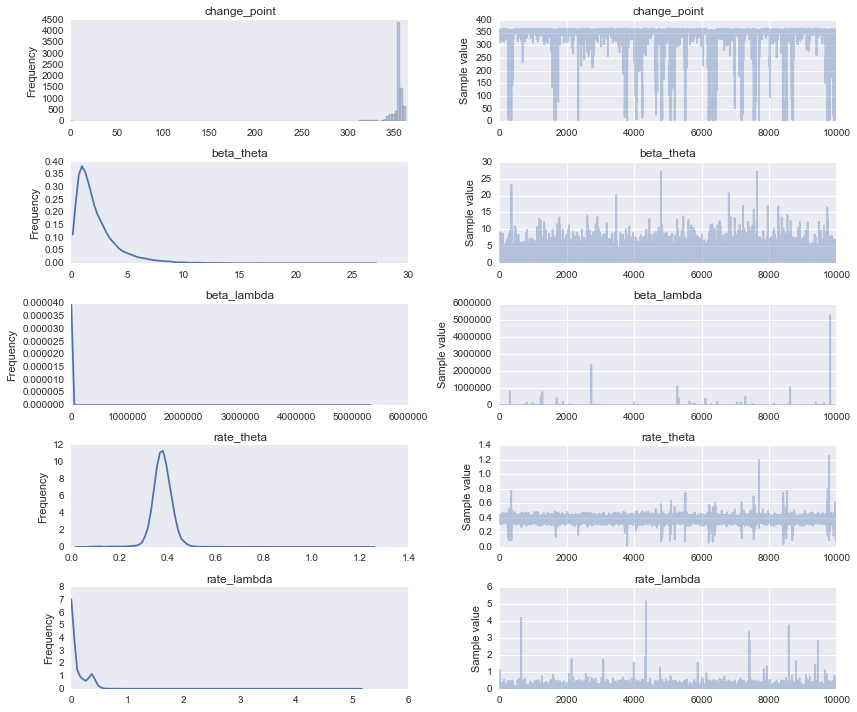

In [79]:
# Check the results
burn_in = 900000 # Posterior sample to discard
thin = 10 # Posterior sample to discard

# Plot Kernal Density Estimates and sampled values for each parameter
pm.traceplot(trace[burn_in::thin])

In [80]:
# Load trace
#trace = pickle.load(open("s1p4.pkl", 'rb'))

In [81]:
print trace.varnames
# rate_theta_samples = trace['rate_theta'][:]
# rate_lambda_samples = trace['rate_lambda'][:]
# change_point_samples = trace['change_point'][:]
rate_theta_samples = trace['rate_theta'][burn_in::thin]
rate_lambda_samples = trace['rate_lambda'][burn_in::thin]
change_point_samples = trace['change_point'][burn_in::thin]

# Mode
m = stats.mode(change_point_samples)
print m

['beta_theta_log', 'beta_lambda_log', 'rate_theta_log', 'rate_lambda_log', 'change_point', 'beta_theta', 'beta_lambda', 'rate_theta', 'rate_lambda']
ModeResult(mode=array([355]), count=array([1995]))


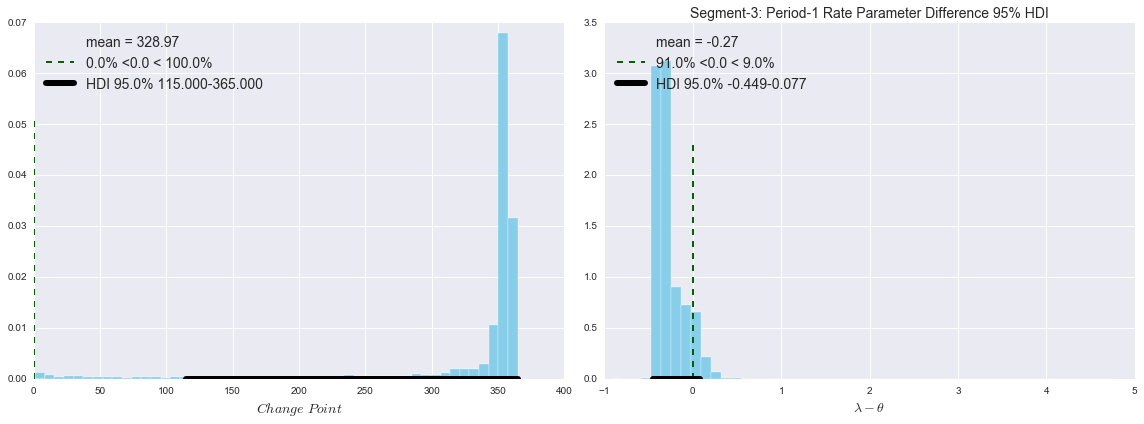

In [82]:
from plot_post import *

fig = plt.figure(figsize=(16, 6))

# Plot switchpoint
plt.subplot(1, 2, 1)
plot_post(change_point_samples, xlab=r'$Change\ Point}$', show_mode=False, comp_val=0, framealpha=0.5)

# Plot differences among rate parameters
plt.subplot(1, 2, 2)
TITLE = 'Segment-3: Period-2 Rate Parameter Difference 95% HDI'
plot_post((rate_lambda_samples - rate_theta_samples),  title = TITLE,
          xlab=r'$\lambda-\theta$', show_mode=False, comp_val=0, framealpha=0.5)


plt.tight_layout()
plt.show()

95% HDI - There is 95% chance that the parameter of interest lies in this interval

Nature of MCMC algorithm -> Returned samples will exhibit autocorrelation

**Autocorrelation** is a measure of how related a series of numbers is with itself, i.e. If you know the position of series at time $t$, can this help you to know the position of series at time $t'$?

Example:
- $x_t \sim N(0, 1)$ -> No autocorrelation
- $y_t \sim N(y_{t-1}, 1), y_0 = 0$ -> Autocorrelation

As lag between time points increases autocorrelation decreases

- Thinning - Autocorrelation can be reduced by returning nth sample

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x16a0ee050>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x161301fd0>]], dtype=object)

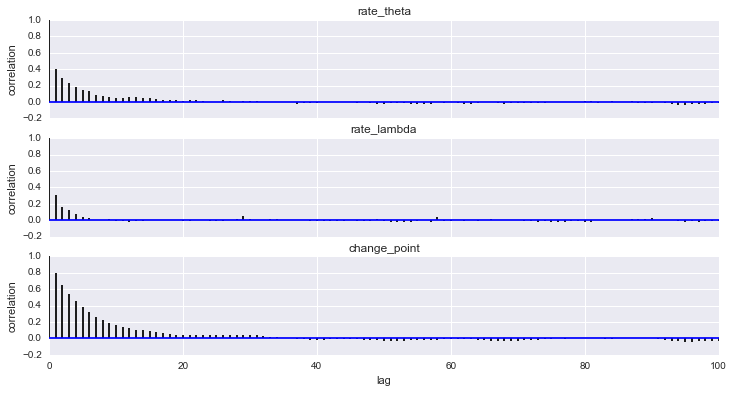

In [77]:
# Plot Autocorrelation
pm.autocorrplot(trace[burn_in::thin], varnames=[rate_theta, rate_lambda, change_point])

In [43]:
# How often rate_theta < rate_lambda?
print (rate_theta_samples < rate_lambda_samples).sum()
print (rate_theta_samples < rate_lambda_samples).mean()

5005
0.5005


In [59]:
help(pm.plot_posterior)

Help on function plot_posterior in module pymc3.plots:

plot_posterior(trace, varnames=None, figsize=None, alpha_level=0.05, round_to=3, point_estimate='mean', rope=None, ref_val=None, kde_plot=False, ax=None, **kwargs)
    Plot Posterior densities in style of John K. Kruschke book
    
    Parameters
    ----------
    
    trace : result of MCMC run
    varnames : list of variable names
        Variables to be plotted, if None all variable are plotted
    figsize : figure size tuple
        If None, size is (12, num of variables * 2) inch
    alpha_level : float
        Defines range for High Posterior Density
    round_to : int
        Controls formatting for floating point numbers
    point_estimate: str
        Must be in ('mode', 'mean', 'median')
    rope: list or numpy array
        Lower and upper values of the Region Of Practical Equivalence
    ref_val: bool
        display the percentage below and above ref_val
    kde_plot: bool
        if True plot a KDE instead of a hist